# Import modules

In [65]:
import sys
import os.path as op

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm
from sklearn.metrics import cohen_kappa_score

sys.path.append(op.join(op.expanduser("~"), "code", "style"))
from colors import get_colors
co, palettes = get_colors()

sys.path.append(op.join(op.expanduser("~"), "code"))
from general.basic.helper_funcs import *
from general.basic.str_methods import *
colors = [
    "2E45B8",
    "3EBCD2",
    "FF4983",
    "1DC9A4",
    "F9C31F",
    "B38FE7",
    "F97A1F",
    "E3120B",
]
font = {"tick": 10, "label": 12, "title": 14, "annot": 12}
pad = {"tick": 2, "label": 5, "title": 8}
colws = {1: 2.05, 2: 3.125, 3: 7.28346}
lws = {"axis": 0.8, "line": 1.5, "marker": 0.8}

%matplotlib inline
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["axes.formatter.offset_threshold"] = 2
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.grid.which"] = "both"
mpl.rcParams["axes.labelpad"] = pad["label"]
mpl.rcParams["axes.labelsize"] = font["label"]
mpl.rcParams["axes.linewidth"] = lws["axis"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler("color", colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.titlepad"] = pad["title"]
mpl.rcParams["axes.titlesize"] = font["title"]
mpl.rcParams["figure.autolayout"] = True
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (colws[3], colws[3]*0.618034)
mpl.rcParams["figure.labelsize"] = font["label"]
mpl.rcParams["figure.subplot.hspace"] = 0.2
mpl.rcParams["figure.subplot.wspace"] = 0.2
mpl.rcParams["figure.titlesize"] = font["title"]
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.serif'] = "Times New Roman"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["grid.alpha"] = 0.5
mpl.rcParams["grid.color"] = "#B7C6CF"
mpl.rcParams["grid.linewidth"] = 0.2
mpl.rcParams["hist.bins"] = 30
mpl.rcParams["legend.borderaxespad"] = 0
mpl.rcParams["legend.fontsize"] = font["tick"]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.handletextpad"] = 0.4
mpl.rcParams["legend.markerscale"] = 1
mpl.rcParams["legend.title_fontsize"] = font["label"]
mpl.rcParams["lines.color"] = colors[0]
mpl.rcParams["lines.linewidth"] = lws["line"]
mpl.rcParams["lines.markeredgewidth"]: lws["marker"]
mpl.rcParams["lines.markersize"] = 8
mpl.rcParams["patch.facecolor"] = colors[1]
mpl.rcParams["patch.linewidth"] = lws["marker"]
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["savefig.directory"] = "~/Downloads"
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["savefig.pad_inches"] = 0.05
mpl.rcParams["xtick.labelsize"] = font["tick"]
mpl.rcParams["xtick.major.size"] = 4
mpl.rcParams["xtick.major.width"] = lws["axis"]
mpl.rcParams["xtick.minor.ndivs"] = 2
mpl.rcParams["ytick.labelsize"] = font["tick"]
mpl.rcParams["ytick.major.size"] = 4
mpl.rcParams["ytick.major.width"] = lws["axis"]
mpl.rcParams["ytick.minor.ndivs"] = 2


# Import data

In [66]:
proj_dir = "/Users/dschonhaut/Box/projects/ideas_visual_quant"
ssheet_dir = op.join(proj_dir, "data", "ssheets")
fig_dir = op.join(proj_dir, "figs")
infile = op.join(ssheet_dir, "IDEAS_CL_VisConf_2023-05-15.xlsx")
save_output = False
overwrite = True

# Import the data
dat = pd.read_excel(infile)

# Format the data

# Get rid of rows with missing data
dat.dropna(inplace=True)
dat.reset_index(drop=True, inplace=True)

# Rename columns and category names.
dat.rename(
    columns={
        "ID": "subj",
        "CL_excl_anatomical": "cl",
        "AF_AMYLOID_RESULT": "vr",
        "AF_RESULT_CONFIDENCE": "vr_conf",
        "Concordance": "vqa",
        "AF_IMAGE_QUANTIFICATION": "read_used_quant",
    },
    inplace=True,
)
dat.replace(
    {
        "vr": {
            1: "pos",
            2: "neg",
            3: "uninterpretable",
        },
        "vr_conf": {
            1: "low",
            2: "intermediate",
            3: "high",
        },
        "vqa": {
            "vis+quant+": "v+q+",
            "vis+quant-": "v+q-",
            "vis-quant+": "v-q+",
            "vis-quant-": "v-q-",
        },
    },
    inplace=True,
)

# Reorder category levels
dat["vr"] = pd.Categorical(
    dat["vr"],
    categories=["pos", "neg", "uninterpretable"],
    ordered=True,
)
dat["vr_conf"] = pd.Categorical(
    dat["vr_conf"],
    categories=["low", "intermediate", "high"],
    ordered=True,
)
dat["vqa"] = pd.Categorical(
    dat["vqa"],
    categories=["v+q+", "v+q-", "v-q+", "v-q-"],
    ordered=True,
)

# Add a column with numeric values for the vr_conf categories
dat.insert(4, "vr_conf_num", dat["vr_conf"].cat.codes)
dat["vr_conf_num"] /= 2

# Change column data types
dat["read_used_quant"] = dat["read_used_quant"].astype(bool)

# Save the data
if save_output:
    outfile = op.join(ssheet_dir, f"dat_{today()}.csv")
    if overwrite or not op.exists(outfile):
        dat.to_csv(outfile, index=False)
        print(f"Saved dat to {outfile}")

print(f"Data shape: {dat.shape}")


Data shape: (10350, 7)


# Raw VR confidence by CL

## Conditional density plot

In [67]:
fig_dir = op.join(proj_dir, "figs")


Saved /Users/dschonhaut/Box/projects/ideas_visual_quant/figs/cl_vs_conf_cond_kde_plot.pdf


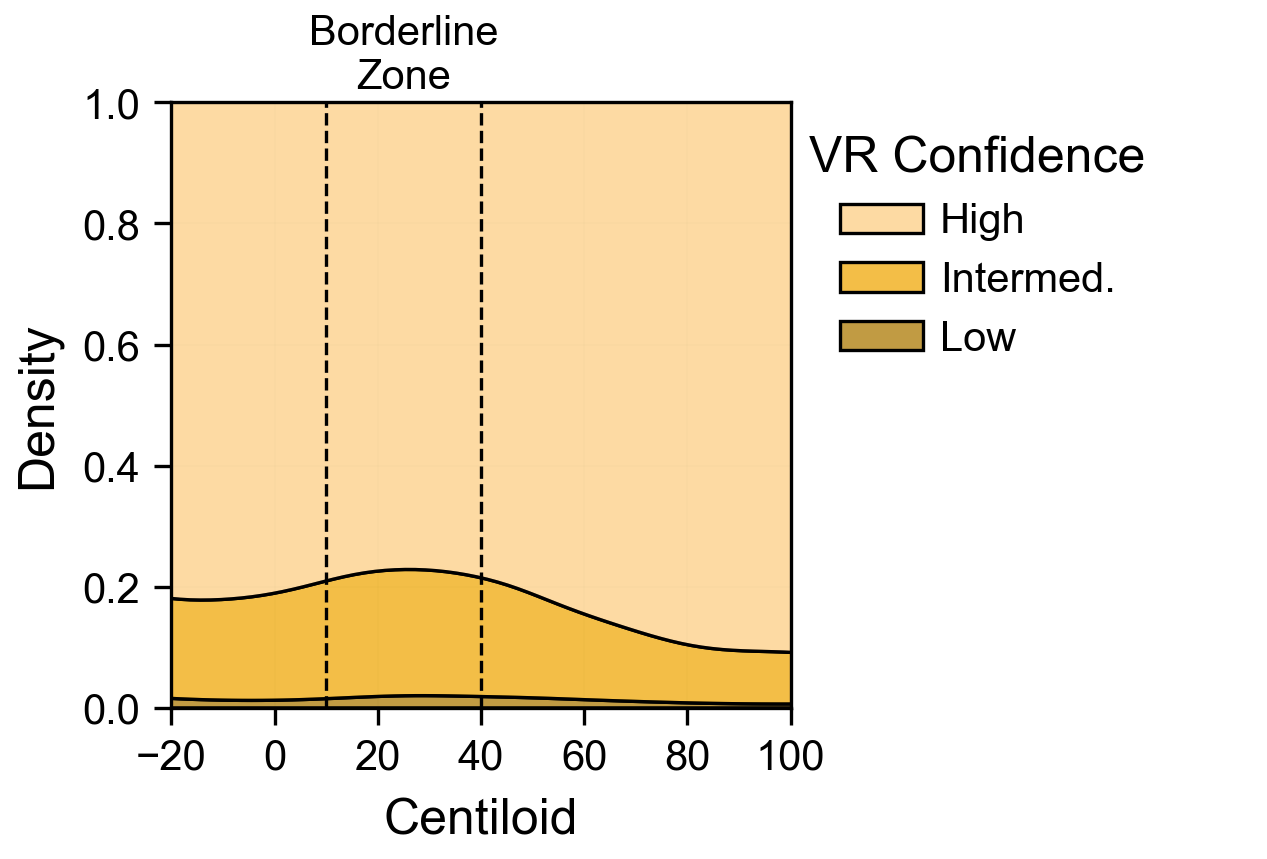

In [166]:
savefig = False
overwrite = True
# xlim = np.percentile(dat["cl"], [5, 95])
xlim = [-20, 100]
xticks = np.arange(-20, 101, 20).astype(int)
yellows = ["#FDCE84", "#EFA909", "#AD7A04"]
# --------------------
plt.close()
fg = sns.displot(
    data=dat,
    x="cl",
    hue="vr_conf",
    hue_order=["high", "intermediate", "low"],
    kind="kde",
    height=6,
    multiple="fill",
    palette=yellows,  # "ch:rot=-.25,hue=1,light=.75",
    common_norm=True,
    bw_adjust=1,
)

# Get the axis
ax = fg.axes[0][0]

# Add vertical lines at x = 10 and x = 40
ax.axvline(x=10, color=co["k"], linestyle="--", linewidth=0.8)
ax.axvline(x=40, color=co["k"], linestyle="--", linewidth=0.8)
ax.annotate(
    "Borderline\nZone",
    xy=(25, 0.9),
    xytext=(25, 1.01),
    xycoords="data",
    textcoords="data",
    ha="center",
    va="bottom",
    fontsize=font["tick"],
    color=co["k"],
)

# Get the legend from fg
leg = fg._legend
leg.set_title("VR Confidence")
leg.set_bbox_to_anchor((1.33, 0.875))

# Change the legend labels and font size
for t, l in zip(leg.texts, ["High", "Intermed.", "Low"]):
    t.set_text(l.capitalize())

ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xlabel("Centiloid")
ax.set_ylabel("Density")
# ax.set_title("CL score distribution by VR confidence")

ax.spines["right"].set_visible(True)
ax.spines["top"].set_visible(True)

# Change the figure size
fg.fig.set_figwidth(colws[3] * 0.4)
fg.fig.set_figheight(colws[3] * 0.4 * 0.8)

if savefig:
    outfile = op.join(fig_dir, "cl_vs_conf_cond_kde_plot.pdf")
    if overwrite or not op.exists(outfile):
        fg.savefig(outfile)
        print(f"Saved {outfile}")

plt.show()


# Mean VR confidence by CL

In [69]:
# Write a function to calculate bootstrap BCa confidence intervals
# and calculate BCa confidence intervals for the mean vr_conf_num
# within cl bins
def resample_calc_ymean_by_xbin(
    df, x="cl", y="vr_conf_num", n_resamples=10000, **kwargs
):
    """Resample df rows with replacement.

    Each resampled dataset is drawn with replacement from the original
    dataset and is passed to calc_ymean_by_xbin to calculate the mean
    of y within each x bin. The confidence intervals are calculated
    from the distribution of resampled means for each x bin.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing the data.
    n_resamples : int, optional
        Number of bootstrap samples to draw, by default 10000.
    **kwargs : dict
        Keyword arguments to pass to calc_ymean_by_xbin.

    Returns
    -------
    y_ci : pandas.DataFrame
        Dataframe containing the BCa confidence intervals.
    """
    # Grab random samples of df rows.
    samples = [
        df.loc[:, [x, y]].sample(frac=1, replace=True, axis=0)
        for _ in range(n_resamples)
    ]

    # Calculate the mean of y within each x bin for each sample
    y_means = [calc_ymean_by_xbin(x, y, data=sample, **kwargs) for sample in samples]

    return y_means


if False:
    sample_y_means = bootstrap_calc_ymean_by_xbin(
        dat,
        x="cl",
        y="vr_conf_num",
        n_resamples=100,
        xmin=-30,
        xmax=140,
        xstep=1,
        bin_width=10,
    )
    sample_y_means = pd.concat([df for df in sample_y_means], axis=1)
    sample_y_means.columns = np.arange(sample_y_means.shape[1])


In [70]:
def calc_ymean_by_xbin(
    x, y, data=None, xmin=-20, xmax=100, xstep=1, bin_width=10, min_bin_size=30
):
    """Calculate mean of y within overlapping bins of x.

    Parameters
    ----------
    x : array vector or str
        A vector of numbers or column name to use from data. x must be a
        string if data is passed.
    y : array vector or str
        A vector of numbers or column name to use from data. y must be a
        string if data is passed.
    data : pandas.DataFrame, optional
        Dataframe containing the data, by default None. This argument
        is required if x and y are column names.
    xmin : int, optional
        Minimum value of x, by default -20.
    xmax : int, optional
        Maximum value of x, by default 100.
    xstep : int, optional
        Step size for x, by default 1.
    bin_width : int, optional
        Width of the bins, by default 10.
    min_bin_size : int, optional
        Minimum number of observations in a bin to calculate the mean of
        y within the bin, by default 30. If fewer than min_bin_size
        observations of x are found for a given bin, the mean of y
        within that bin is set to NaN.

    Returns
    -------
    y_means : pandas.DataFrame
        Dataframe containing the mean of y within each bin.
    """
    if data is None:
        y_means_cols = ["x", "x_count", "y"]
        x = np.asanyarray(x)
        y = np.asanyarray(y)
        assert x.size == y.size
        assert x.ndim == 1 and y.ndim == 1
    else:
        y_means_cols = [x, f"{x}_count", y]
        x = data[x].values
        y = data[y].values
    if np.any([xmin is None, xmax is None]):
        start, stop = np.rint(np.percentile(x, [2.5, 97.5]))
        x_bin_centers = np.arange(start, stop + 1, xstep)
    else:
        x_bin_centers = np.arange(xmin, xmax + xstep, xstep)
    hw = bin_width / 2

    # For each xi in x_bin_centers, calculate mean(y[(xi-hw<=x<xi+hw)])
    y_means = []
    x_bin_counts = []
    for xi in x_bin_centers:
        y_xi = y[(x >= xi - hw) & (x < xi + hw)]
        x_bin_counts.append(y_xi.size)
        if y_xi.size <= min_bin_size:
            y_means.append(np.nan)
        else:
            y_means.append(y_xi.mean())

    # Convert to dataframe and return
    y_means = pd.DataFrame(
        np.array([x_bin_centers.tolist(), x_bin_counts, y_means]).T,
        columns=y_means_cols,
    )

    return y_means


def calc_ymean_by_xbin_fast(
    x,
    y,
    x_bin_centers=None,
    hw=5,
    min_bin_size=30,
):
    """Calculate mean of y within overlapping bins of x.

    Parameters
    ----------
    x : array vector
        A vector of numbers.
    y : array vector
        A vector of numbers.
    x_bin_centers : array vector, optional
        Array of x bin centers, by default None. If None, x_bin_centers
        is set to np.arange(-20, 100 + 1, 1).
    hw : int, optional
        Half-width of the bins, by default 5.
    min_bin_size : int, optional
        Minimum number of observations in a bin to calculate the mean of
        y within the bin, by default 30. If fewer than min_bin_size
        observations of x are found for a given bin, the mean of y
        within that bin is set to NaN.

    Returns
    -------
    y_means : list
        List containing the mean of y within each bin.
    """
    if x_bin_centers is None:
        start, stop = -20, 100
        x_bin_centers = np.arange(start, stop + 1, 1)

    y_means = []
    for xi in x_bin_centers:
        y_xi = y[np.where((x >= xi - hw) & (x < xi + hw))[0]]
        if y_xi.size < min_bin_size:
            y_means.append(np.nan)
        else:
            y_means.append(y_xi.mean())
    return y_means


def bootstrap_calc_ymean_by_xbin(x, y, data=None, n_resamples=10000, method="BCa"):
    """Calculate bootstrap CIs for the mean of y within each x bin.

    Parameters
    ----------
    x : array vector or str
        A vector of numbers or column name to use from data. x must be a
        string if data is passed.
    y : array vector or str
        A vector of numbers or column name to use from data. y must be a
        string if data is passed.
    data : pandas.DataFrame, optional
        Dataframe containing the data, by default None. This argument
        is required if x and y are column names.
    n_resamples : int, optional
        Number of bootstrap samples to draw, by default 10000.
    method : str, optional
        Method to use to calculate the bootstrap confidence intervals,
        by default "BCa".

    Returns
    -------
    y_ci_bca : BootstrapResult
        An object with attributes:
        confidence_interval : ConfidenceInterval
            The bootstrap confidence interval as an instance of
            collections.namedtuple with attributes low and high.
        bootstrap_distribution : ndarray
            The bootstrap distribution, that is, the value of statistic
            for each resample. The last dimension corresponds with the
            resamples (e.g. res.bootstrap_distribution.shape[-1] ==
            n_resamples).
        standard_error : float or ndarray
            The bootstrap standard error, that is, the sample standard
            deviation of the bootstrap distribution.
    """
    if data is None:
        x = np.asanyarray(x)
        y = np.asanyarray(y)
        assert x.size == y.size
        assert x.ndim == 1 and y.ndim == 1
    else:
        x = data[x].values
        y = data[y].values

    y_ci_bca = stats.bootstrap(
        (x, y),
        calc_ymean_by_xbin_fast,
        n_resamples=n_resamples,
        paired=True,
        method=method,
    )
    return y_ci_bca


In [73]:
xcol = "cl"
ycol = "vr_conf_num"
n_resamples = 5000
save_output = True
overwrite = True

# Calculate mean vr_conf_num within 10-cl bins spaced 1-cl apart
y_means = calc_ymean_by_xbin(
    x=xcol,
    y=ycol,
    data=dat,
    xmin=-20,
    xmax=100,
    xstep=1,
    bin_width=10,
    min_bin_size=30,
)

# Calculate bootstrap BCa confidence intervals for the mean vr_conf_num
# within cl bins
y_ci_bca = bootstrap_calc_ymean_by_xbin(xcol, ycol, data=dat, n_resamples=n_resamples)

# Organize the data
cl_conf = y_means.copy()
cl_conf["lower_ci"] = y_ci_bca.confidence_interval.low
cl_conf["upper_ci"] = y_ci_bca.confidence_interval.high

# Save the data
if save_output:
    outfile = op.join(ssheet_dir, f"cl_conf_{today()}.csv")
    if overwrite or not op.exists(outfile):
        cl_conf.to_csv(outfile, index=False)
        print(f"Saved {outfile}")

print(f"cl_conf shape: {cl_conf.shape}")


Saved /Users/dschonhaut/Box/projects/ideas_visual_quant/data/ssheets/cl_conf_2023-11-22.csv
cl_conf shape: (121, 5)


In [ ]:
xcol = "cl"
ycol = "vr_conf_num"
n_resamples = 5000
save_output = True
overwrite = True

# Calculate mean vr_conf_num within 10-cl bins spaced 1-cl apart
dat_vr = {}
y_means_vr = {}
y_ci_bca_vr = {}
cl_conf_vr = {}
for vr in ["neg", "pos"]:
    print(vr)
    dat_vr[vr] = dat[dat["vr"] == vr].copy()
    y_means_vr[vr] = calc_ymean_by_xbin(
        x=xcol,
        y=ycol,
        data=dat_vr[vr],
        xmin=-20,
        xmax=100,
        xstep=1,
        bin_width=10,
        min_bin_size=30,
    )

    # Calculate bootstrap BCa confidence intervals for the mean vr_conf_num
    # within cl bins
    y_ci_bca_vr[vr] = bootstrap_calc_ymean_by_xbin(
        xcol, ycol, data=dat_vr[vr], n_resamples=n_resamples
    )

    # Organize the data
    cl_conf_vr[vr] = y_means_vr[vr].copy()
    cl_conf_vr[vr]["lower_ci"] = y_ci_bca_vr[vr].confidence_interval.low
    cl_conf_vr[vr]["upper_ci"] = y_ci_bca_vr[vr].confidence_interval.high

# Combine the dataframes
df1 = cl_conf_vr["neg"].dropna()
df1.insert(0, "vr", "neg")
df2 = cl_conf_vr["pos"].dropna()
df2.insert(0, "vr", "pos")
cl_conf_vr = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# Save the data
if save_output:
    outfile = op.join(ssheet_dir, f"cl_conf_vr_{today()}.csv")
    if overwrite or not op.exists(outfile):
        cl_conf_vr.to_csv(outfile, index=False)
        print(f"Saved {outfile}")

print(f"cl_conf_vr shape: {cl_conf_vr.shape}")


neg


/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


pos
Saved /Users/dschonhaut/Box/projects/ideas_visual_quant/data/ssheets/cl_conf_vr_2023-11-22.csv
cl_conf_vr shape: (209, 6)


In [ ]:
xcol = "cl"
ycol = "vr_conf_num"
n_resamples = 5000
save_output = True
overwrite = True

# Calculate mean vr_conf_num within 10-cl bins spaced 1-cl apart
dat_ruq = {}
y_means_ruq = {}
y_ci_bca_ruq = {}
cl_conf_ruq = {}
for ruq in [False, True]:
    print(ruq)
    dat_ruq[ruq] = dat[dat["read_used_quant"] == ruq].copy()
    y_means_ruq[ruq] = calc_ymean_by_xbin(
        x=xcol,
        y=ycol,
        data=dat_ruq[ruq],
        xmin=-20,
        xmax=100,
        xstep=1,
        bin_width=10,
        min_bin_size=30,
    )

    # Calculate bootstrap BCa confidence intervals for the mean vr_conf_num
    # within cl bins
    y_ci_bca_ruq[ruq] = bootstrap_calc_ymean_by_xbin(
        xcol, ycol, data=dat_ruq[ruq], n_resamples=n_resamples
    )

    # Organize the data
    cl_conf_ruq[ruq] = y_means_ruq[ruq].copy()
    cl_conf_ruq[ruq]["lower_ci"] = y_ci_bca_ruq[ruq].confidence_interval.low
    cl_conf_ruq[ruq]["upper_ci"] = y_ci_bca_ruq[ruq].confidence_interval.high

# Combine the dataframes
df1 = cl_conf_ruq[False].dropna()
df1.insert(0, "read_used_quant", False)
df2 = cl_conf_ruq[True].dropna()
df2.insert(0, "read_used_quant", True)
cl_conf_ruq = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# Save the data
if save_output:
    outfile = op.join(ssheet_dir, f"cl_conf_ruq_{today()}.csv")
    if overwrite or not op.exists(outfile):
        cl_conf_ruq.to_csv(outfile, index=False)
        print(f"Saved {outfile}")

print(f"cl_conf_ruq shape: {cl_conf_ruq.shape}")


False
True
Saved /Users/dschonhaut/Box/projects/ideas_visual_quant/data/ssheets/cl_conf_ruq_2023-11-22.csv
cl_conf_ruq shape: (242, 6)


## Line plots

Text(0, 0.5, 'VR Confidence')

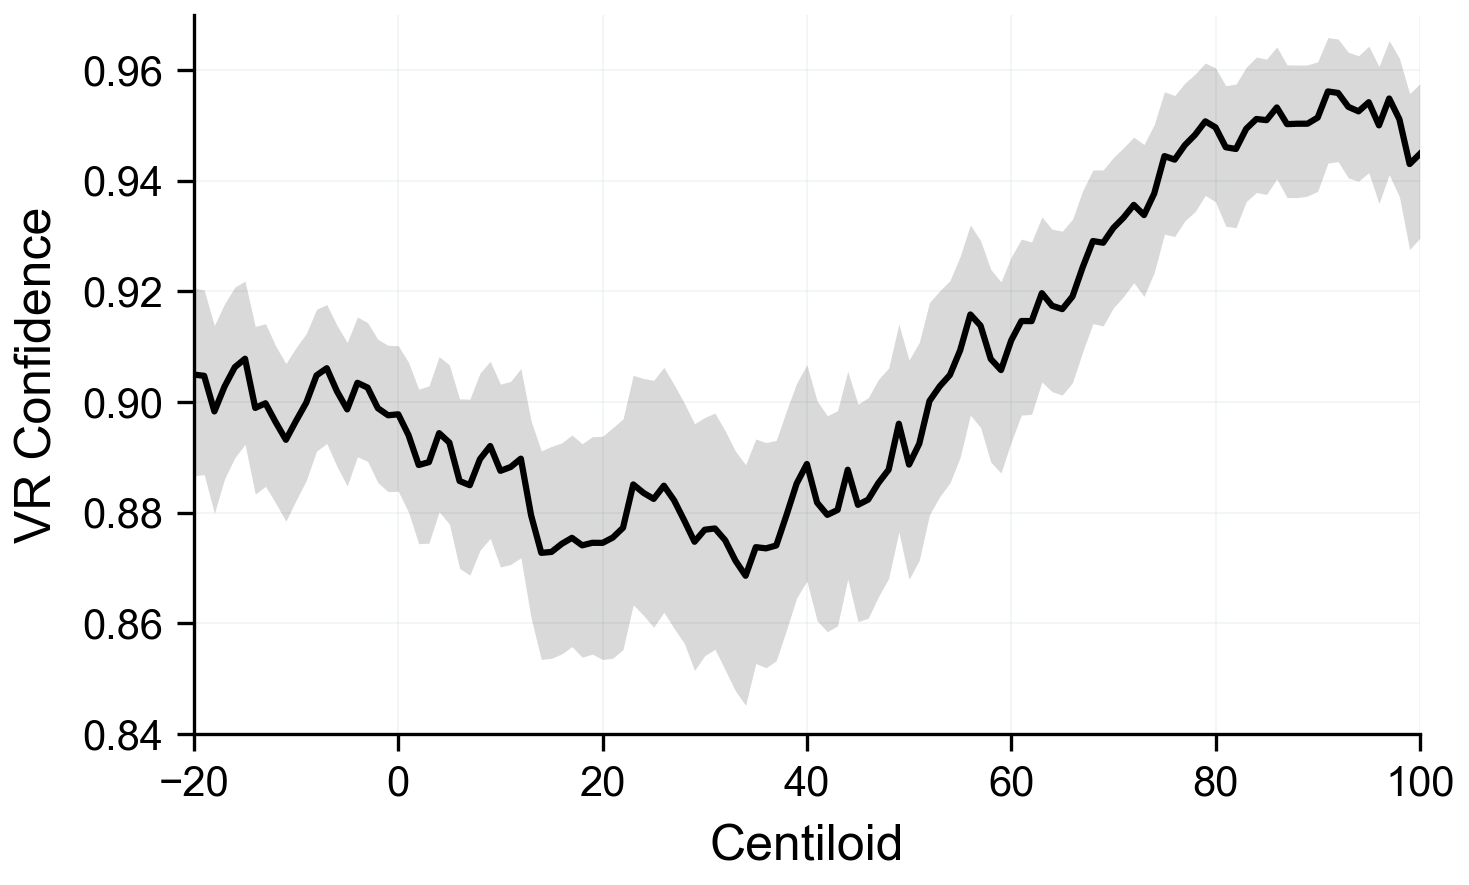

In [85]:
savefig = False
overwrite = True

# Graph this
fig, ax = plt.subplots(figsize=(colws[3] * 0.7, colws[3] * 0.7 * 0.618034))
ax.plot(cl_conf[xcol], cl_conf[ycol], color="k", linewidth=lws["line"])
ax.fill_between(
    cl_conf[xcol],
    cl_conf["lower_ci"],
    cl_conf["upper_ci"],
    color="k",
    alpha=0.15,
    lw=0,
)
ax.set_xlim(-20, 100)
ax.set_xticks(np.arange(-20, 101, 20))
ax.set_xlabel("Centiloid")
ax.set_ylim([0.84, 0.97])
# ax.set_yticks(np.arange(1.7, 1.96, 0.05))
# ax.set_ylim([1.3, 2.0])
# ax.set_yticks(np.arange(1.3, 2.01, 0.1))
ax.set_ylabel("VR Confidence")


In [116]:
cl_conf["cl"]


,cl,cl_count,vr_conf_num,lower_ci,upper_ci
0,-20.0,626.0,0.904952,0.886656,0.920597
1,-19.0,656.0,0.904726,0.886878,0.920231
2,-18.0,703.0,0.898293,0.879861,0.913812
3,-17.0,746.0,0.902815,0.886124,0.917764
4,-16.0,779.0,0.906290,0.889922,0.920759
...,...,...,...,...,...
116,96.0,600.0,0.950000,0.935884,0.960659
117,97.0,598.0,0.954849,0.941094,0.965313
118,98.0,593.0,0.951096,0.937067,0.962133
119,99.0,579.0,0.943005,0.927549,0.955729


In [128]:
dat["cl"]


,subj,cl,vr,vr_conf,vr_conf_num,vqa,read_used_quant
0,50001,-72.441372,neg,high,1.0,v-q-,True
1,50002,40.527069,pos,high,1.0,v+q+,False
2,50003,123.512360,pos,high,1.0,v+q+,False
3,50004,113.339699,pos,high,1.0,v+q+,False
4,50005,85.186910,neg,low,0.0,v-q+,False
...,...,...,...,...,...,...,...
10345,64677,21.089931,pos,high,1.0,v+q-,False
10346,64678,54.558794,pos,high,1.0,v+q+,False
10347,64679,23.128265,pos,high,1.0,v+q-,False
10348,64680,87.001093,pos,intermediate,0.5,v+q+,False


/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_43153/566403553.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.savefig(outfile)
/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)


Saved /Users/dschonhaut/Box/projects/ideas_visual_quant/figs/cl_vs_conf_violin_plots.pdf


/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


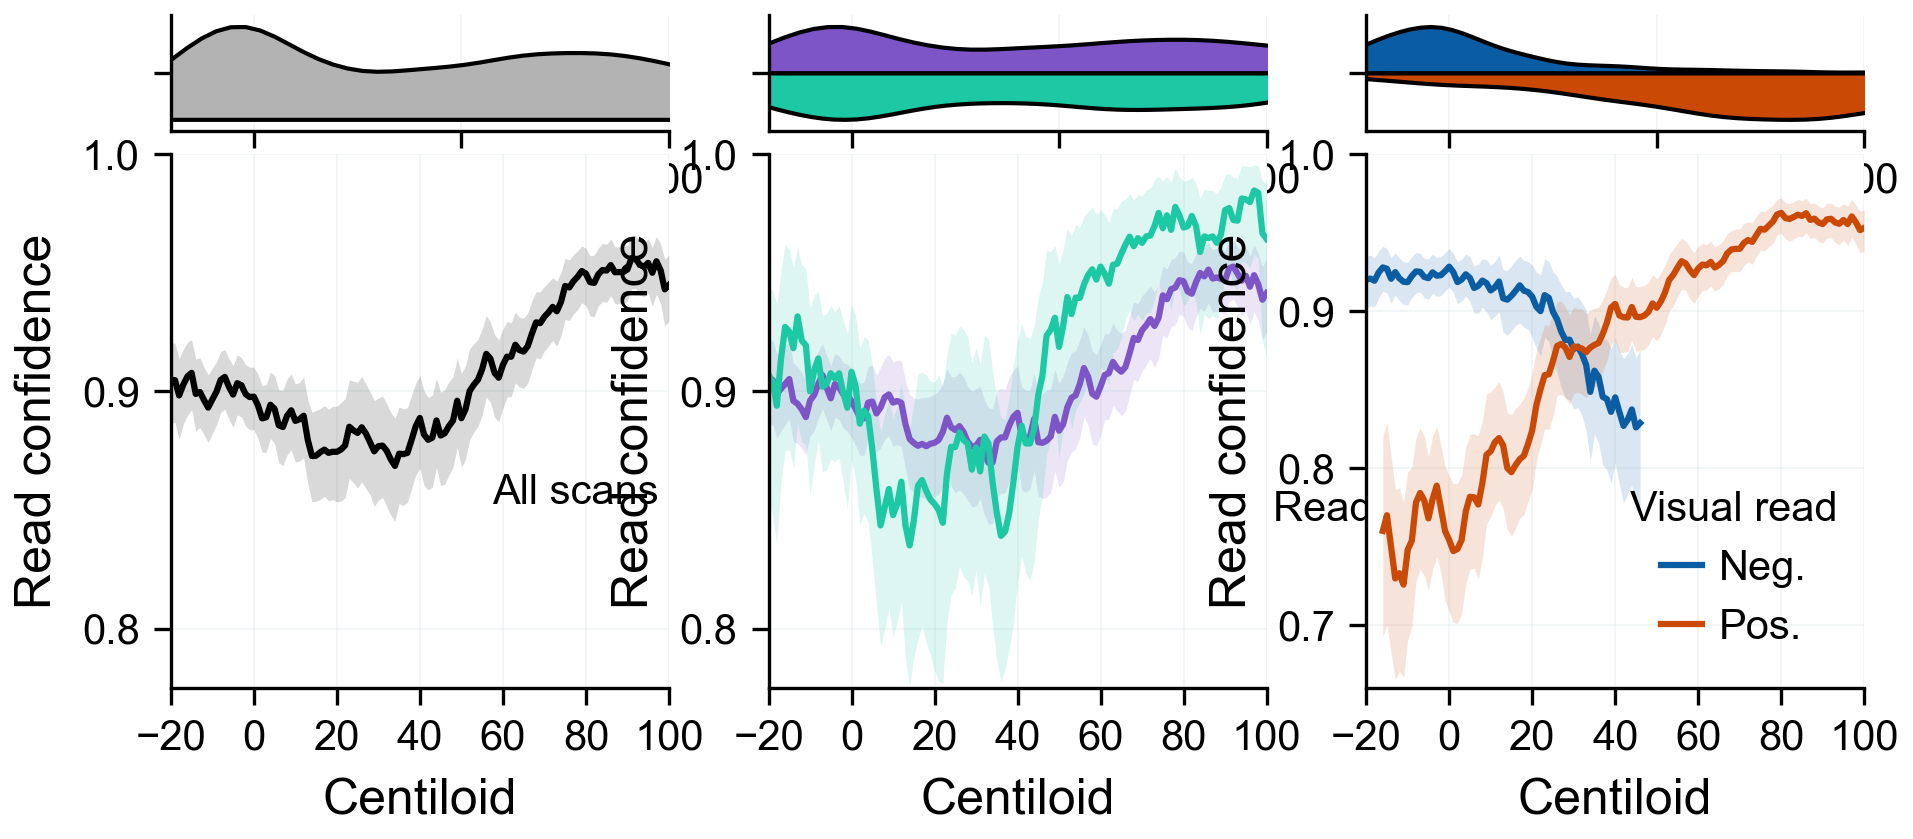

In [164]:
savefig = True
overwrite = True
vr_palette = ["#0B5DA3", "#C94905"]
ruq_palette = [co["v3"], co["g"]]

# --------------------------------
fig = plt.figure(figsize=(colws[3], colws[3] * 0.4))
gs = fig.add_gridspec(5, 3)
ax = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1:, 0]),
    fig.add_subplot(gs[1:, 1]),
    fig.add_subplot(gs[1:, 2]),
]

# --------------------------------
iax = 0
_ax = ax[iax]
sns.violinplot(
    x="cl",
    color=co["x3"],
    linecolor="k",
    data=dat,
    ax=_ax,
    split=True,
    inner=None,
    cut=0,
    alpha=1,
    saturation=1,
)
_ax.set_xlim(-20, 100)

# --------------------------------
iax += 1
_ax = ax[iax]
sns.violinplot(
    x="cl",
    hue="read_used_quant",
    hue_order=[False, True],
    palette=ruq_palette,
    data=dat,
    ax=_ax,
    split=True,
    inner=None,
    cut=0,
    alpha=1,
    linecolor="k",
    saturation=1,
    legend=False,
)
_ax.set_xlim(-20, 100)

# --------------------------------
iax += 1
_ax = ax[iax]
sns.violinplot(
    x="cl",
    hue="vr",
    hue_order=["neg", "pos"],
    palette=vr_palette,
    data=dat,
    ax=_ax,
    split=True,
    inner=None,
    cut=0,
    alpha=1,
    linecolor="k",
    saturation=1,
    legend=False,
)
_ax.set_xlim(-20, 100)

# --------------------------------
iax = 3
_ax = ax[iax]
_ax.plot(cl_conf[xcol], cl_conf[ycol], color="k", linewidth=lws["line"])
_ax.fill_between(
    cl_conf[xcol],
    cl_conf["lower_ci"],
    cl_conf["upper_ci"],
    color="k",
    alpha=0.15,
    lw=0,
)
_ax.set_xlim(-20, 100)
_ax.set_xticks(np.arange(-20, 101, 20))
_ax.set_xlabel("Centiloid")
# _ax.set_ylim([0.84, 0.97])
# _ax.set_yticks(np.arange(0.85, 0.96, 0.05))
_ax.set_ylim([0.775, 1])
_ax.set_yticks(np.arange(0.8, 1.01, 0.1))
_ax.set_ylabel("Read confidence")
_ax.annotate(
    "All scans",
    xy=(0.98, 0.4),
    # xytext=(0.5, 0.95),
    xycoords="axes fraction",
    textcoords="axes fraction",
    ha="right",
    va="top",
    fontsize=font["tick"],
    color=co["k"],
)

# --------------------------------
iax += 1
_ax = ax[iax]
for i, q in enumerate([False, True]):
    df = cl_conf_ruq.query("(read_used_quant=={}) & (cl_count>=30)".format(q))
    _ax.plot(
        df[xcol],
        df[ycol],
        color=ruq_palette[i],
        linewidth=lws["line"],
        label="No" if (i == 0) else "Yes",
    )
    _ax.fill_between(
        df[xcol],
        df["lower_ci"],
        df["upper_ci"],
        color=ruq_palette[i],
        alpha=0.15,
        lw=0,
    )

_ax.set_xlabel("Centiloid")
_ax.set_xlim(-20, 100)
_ax.set_xticks(np.arange(-20, 101, 20))
_ax.set_ylim([0.775, 1])
_ax.set_yticks(np.arange(0.8, 1.01, 0.1))
_ax.set_ylabel("Read confidence")

# Add the legend
leg = _ax.legend(
    bbox_to_anchor=(0.98, 0.4),
    frameon=False,
    fontsize=font["tick"],
    title_fontsize=font["tick"],
    handlelength=1,
    handletextpad=0.4,
    markerscale=1,
    title="Read used quant.",
)

# --------------------------------
iax += 1
_ax = ax[iax]
for i, vr in enumerate(["neg", "pos"]):
    df = cl_conf_vr.query("(vr=='{}') & (cl_count>=100)".format(vr))
    _ax.plot(
        df[xcol],
        df[ycol],
        color=vr_palette[i],
        linewidth=lws["line"],
        label="Neg." if vr == "neg" else "Pos.",
    )
    _ax.fill_between(
        df[xcol],
        df["lower_ci"],
        df["upper_ci"],
        color=vr_palette[i],
        alpha=0.15,
        lw=0,
    )

_ax.set_xlabel("Centiloid")
_ax.set_xlim(-20, 100)
_ax.set_xticks(np.arange(-20, 101, 20))
_ax.set_ylim([0.66, 1])
_ax.set_yticks(np.arange(0.7, 1.01, 0.1))
_ax.set_ylabel("Read confidence")

# Add the legend
leg = _ax.legend(
    bbox_to_anchor=(0.98, 0.4),
    frameon=False,
    fontsize=font["tick"],
    title_fontsize=font["tick"],
    handlelength=1,
    handletextpad=0.4,
    markerscale=1,
    title="Visual read",
)

if savefig:
    outfile = op.join(fig_dir, "cl_vs_conf_violin_plots.pdf")
    if overwrite or not op.exists(outfile):
        fig.savefig(outfile)
        print(f"Saved {outfile}")


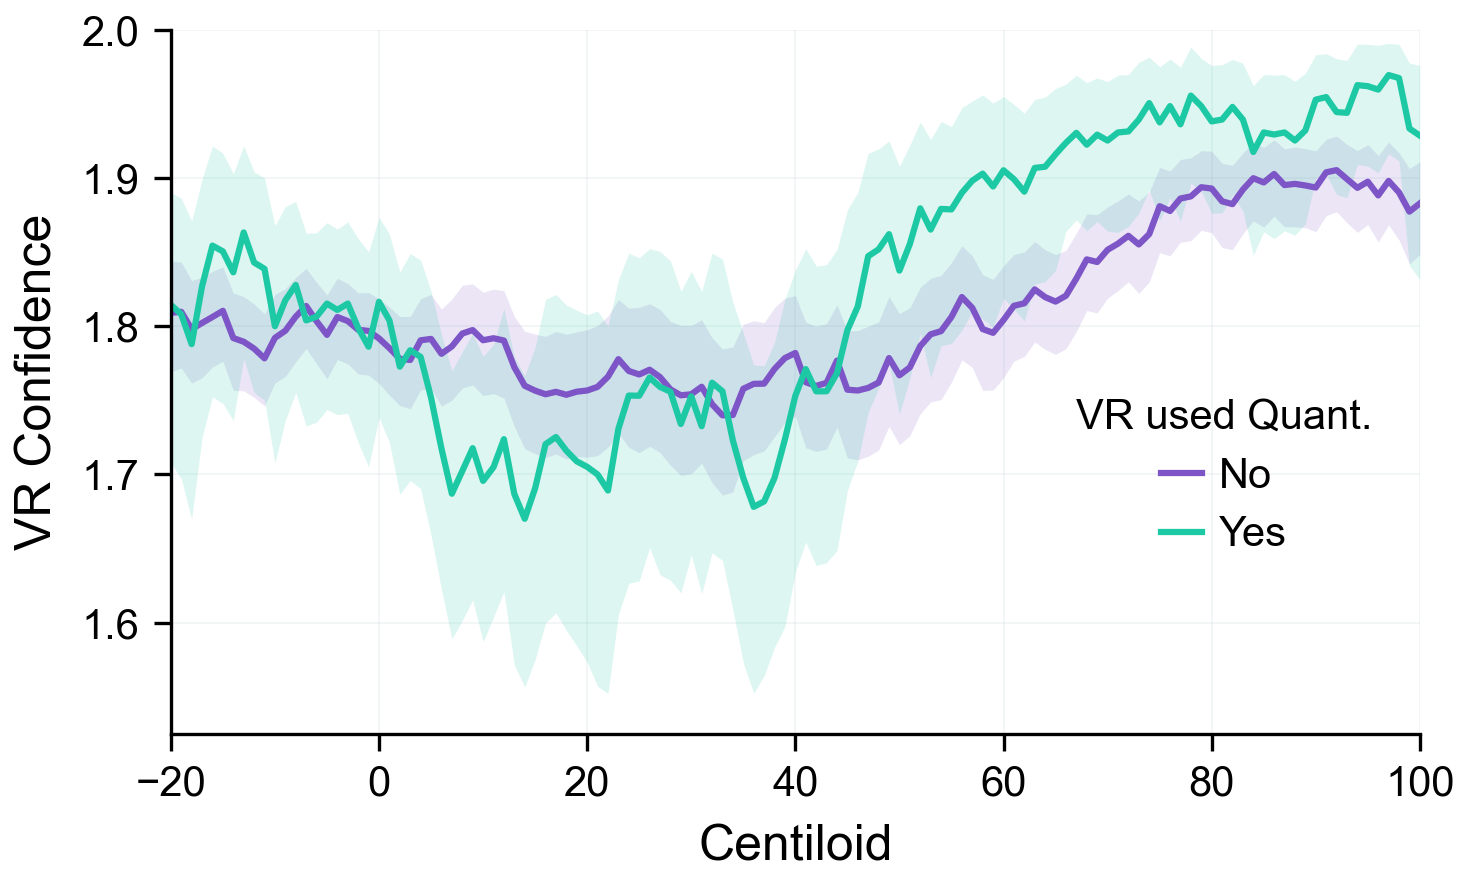

In [ ]:
# Graph this
palette = [co["v3"], co["g"]]
fig, ax = plt.subplots(figsize=(colws[3] * 0.7, colws[3] * 0.7 * 0.618034))

for i, q in enumerate([False, True]):
    df = cl_conf_ruq.query("(read_used_quant=={}) & (cl_count>=30)".format(q))
    ax.plot(
        df[xcol],
        df[ycol],
        color=palette[i],
        linewidth=lws["line"],
        label="No" if (i == 0) else "Yes",
    )
    ax.fill_between(
        df[xcol],
        df["lower_ci"],
        df["upper_ci"],
        color=palette[i],
        alpha=0.15,
        lw=0,
    )

ax.set_xlabel("Centiloid")
ax.set_xlim(-20, 100)
ax.set_xticks(np.arange(-20, 101, 20))
ax.set_ylim([1.525, 2])
ax.set_yticks(np.arange(1.6, 2.01, 0.1))
ax.set_ylabel("VR Confidence")

# Add the legend
leg = ax.legend(
    bbox_to_anchor=(0.975, 0.5),
    frameon=False,
    fontsize=font["tick"],
    title_fontsize=font["tick"],
    handlelength=1,
    handletextpad=0.4,
    markerscale=1,
    title="VR used Quant.",
)


# Cohen's kappa: VR vs. CL threshold

In [ ]:
def vr_quant_kappa(vr, cl, min_cutoff=-20, max_cutoff=100, step=0.1):
    """Calculate Cohen's kappa between visual and quant. results.

    Tests a range of CL thresholds and calculates kappa for each.

    Parameters
    ----------
    vr : array vector
        Visual read result ("pos" or "neg")
    cl : array vector
                Vector of continuous Centiloids.
    min_cutoff : int, optional
                Minimum CL threshold to test, by default -20.
    max_cutoff : int, optional
                Maximum CL threshold to test, by default 100.
    step : int, optional
                Step size for CL thresholds, by default 1.

    Returns
    -------
    kappas : pandas.Series
            Series containing the kappa for each CL threshold.
    """
    cl_cutoffs = np.arange(min_cutoff, max_cutoff + step, step)
    vr_result = vr == "pos"
    kappas = []
    for cl_cutoff in cl_cutoffs:
        cl_result = cl > cl_cutoff
        kappa = cohen_kappa_score(vr_result, cl_result)
        kappas.append(kappa)

    kappas = pd.Series(index=cl_cutoffs, data=kappas)

    return kappas


def bootstrap_vr_quant_kappa(vr, cl, n_resamples=5000, method="BCa", **kws):
    """Calculate bootstrap CIs for the kappa between visual and quant.

    Parameters
    ----------
    vr : array vector
        Visual read result ("pos" or "neg")
    cl : array vector
        Vector of continuous Centiloids.
    n_resamples : int, optional
        Number of bootstrap samples to draw, by default 10000.
    method : str, optional
        Method to use for calculating bootstrap CIs, by default "BCa".

    Returns
    -------
    res : BootstrapResult
        An object with attributes:
        confidence_interval : ConfidenceInterval
            The bootstrap confidence interval as an instance of
            collections.namedtuple with attributes low and high.
        bootstrap_distribution : ndarray
            The bootstrap distribution, that is, the value of statistic
            for each resample. The last dimension corresponds with the
            resamples (e.g. res.bootstrap_distribution.shape[-1] ==
            n_resamples).
        standard_error : float or ndarray
            The bootstrap standard error, that is, the sample standard
            deviation of the bootstrap distribution.
    """

    def vr_quant_kappa_wrapper(vr, cl, **kws):
        return vr_quant_kappa(vr, cl, **kws)

    assert vr.size == cl.size
    assert vr.ndim == 1 and cl.ndim == 1
    res = stats.bootstrap(
        (vr, cl),
        vr_quant_kappa_wrapper,
        n_resamples=n_resamples,
        paired=True,
        method=method,
    )
    return res


def calc_max_kappa(vr_quant):
    """Calculate max kappa and CL threshold within each data group.

    Also return the difference in optimal CL threshold between scans
    that used quantification in the visual read process and those that
    didn't.

    Parameters
    ----------
    vr_quant : pandas.DataFrame
        Dataframe containing the data.

    Returns
    -------
    max_kappa : dict
        Dictionary containing the max kappa ("kappa") and associated CL
        threshold ("cl_thresh") within each data group.
    cl_thresh_diff : float
        Difference in optimal CL threshold between scans that used
        quantification in the visual read process and those that didn't.
    """
    max_kappa = {}
    for k in ["all", "no_quant", "used_quant"]:
        max_kappa[k] = {
            "cl_thresh": np.round(
                vr_quant.query("(data=='{}')".format(k))["cl_thresh"].values[
                    vr_quant.query("(data=='{}')".format(k))["kappa"].argmax()
                ],
                1,
            ),
            "kappa": vr_quant.query("(data=='{}')".format(k))["kappa"].max(),
        }

    # Calculate the difference in optimal CL threshold between scans that
    # used quantification in the visual read process and those that didn't.
    max_kappa_diff = max_kappa["used_quant"]["kappa"] - max_kappa["no_quant"]["kappa"]
    cl_thresh_diff = np.round(
        max_kappa["used_quant"]["cl_thresh"] - max_kappa["no_quant"]["cl_thresh"], 1
    )

    return max_kappa, max_kappa_diff, cl_thresh_diff


In [ ]:
min_cutoff = -20
max_cutoff = 100
step = 0.1
run_bootstrap = False
n_resamples = 100
save_output = True
overwrite = True

# Calculate Cohen's kappa between visual and quant. results for:
# 1. All scans
timer = Timer(msg="time: ")
print("1. All scans")
vr_quant = []
_dat = dat
vr_quant.append(
    vr_quant_kappa(
        _dat["vr"], _dat["cl"], min_cutoff=min_cutoff, max_cutoff=max_cutoff, step=step
    ).reset_index()
)
vr_quant[-1].columns = ["cl_thresh", "kappa"]
vr_quant[-1].insert(0, "data", "all")
if run_bootstrap:
    boot_res = bootstrap_vr_quant_kappa(
        _dat["vr"],
        _dat["cl"],
        n_resamples=n_resamples,
        min_cutoff=min_cutoff,
        max_cutoff=max_cutoff,
        step=step,
    )
    vr_quant[-1]["lower_ci"] = boot_res.confidence_interval.low
    vr_quant[-1]["upper_ci"] = boot_res.confidence_interval.high

# 2. Scans that didn't use quantification in the visual read process
print("2. Scans that didn't use quantification in the visual read process")
print(timer)
_dat = dat.query("(read_used_quant==False)")
vr_quant.append(
    vr_quant_kappa(
        _dat["vr"], _dat["cl"], min_cutoff=min_cutoff, max_cutoff=max_cutoff, step=step
    ).reset_index()
)
vr_quant[-1].columns = ["cl_thresh", "kappa"]
vr_quant[-1].insert(0, "data", "no_quant")
if run_bootstrap:
    boot_res = bootstrap_vr_quant_kappa(
        _dat["vr"],
        _dat["cl"],
        n_resamples=n_resamples,
        min_cutoff=min_cutoff,
        max_cutoff=max_cutoff,
        step=step,
    )
    vr_quant[-1]["lower_ci"] = boot_res.confidence_interval.low
    vr_quant[-1]["upper_ci"] = boot_res.confidence_interval.high

# 3. Scans that used quantification in the visual read process
print("3. Scans that used quantification in the visual read process")
print(timer)
_dat = dat.query("(read_used_quant==True)")
vr_quant.append(
    vr_quant_kappa(
        _dat["vr"], _dat["cl"], min_cutoff=min_cutoff, max_cutoff=max_cutoff, step=step
    ).reset_index()
)
vr_quant[-1].columns = ["cl_thresh", "kappa"]
vr_quant[-1].insert(0, "data", "used_quant")
if run_bootstrap:
    boot_res = bootstrap_vr_quant_kappa(
        _dat["vr"],
        _dat["cl"],
        n_resamples=n_resamples,
        min_cutoff=min_cutoff,
        max_cutoff=max_cutoff,
        step=step,
    )
    vr_quant[-1]["lower_ci"] = boot_res.confidence_interval.low
    vr_quant[-1]["upper_ci"] = boot_res.confidence_interval.high

# Combine the dataframes
vr_quant = pd.concat(vr_quant, axis=0).reset_index(drop=True)

# Calculate the maximum kappa and CL threshold within each data grouping.
max_kappa, max_kappa_diff, cl_thresh_diff = calc_max_kappa(vr_quant)

if save_output:
    outfile = op.join(ssheet_dir, f"vr_quant_{today()}.csv")
    if overwrite or not op.exists(outfile):
        vr_quant.to_csv(outfile, index=False)
        print(f"Saved {outfile}")

print(f"vr_quant shape: {vr_quant.shape}")
for k in max_kappa:
    print(
        "max_kappa['{}']: cl_thresh = {}, kappa = {:.4f}".format(
            k, max_kappa[k]["cl_thresh"], max_kappa[k]["kappa"]
        )
    )
print(f"cl_thresh_diff: {cl_thresh_diff}")
print(timer)


1. All scans
2. Scans that didn't use quantification in the visual read process
time: 1.167s
3. Scans that used quantification in the visual read process
time: 2.199s
Saved /Users/dschonhaut/Box/projects/ideas_visual_quant/data/ssheets/vr_quant_2023-11-22.csv
vr_quant shape: (3603, 3)
max_kappa['all']: cl_thresh = 24.6, kappa = 0.7150
max_kappa['no_quant']: cl_thresh = 24.4, kappa = 0.7028
max_kappa['used_quant']: cl_thresh = 19.7, kappa = 0.7871
cl_thresh_diff: -4.7
time: 2.701s


In [ ]:
def analyze_vr_quant_kappa(
    dat,
    min_cutoff=-20,
    max_cutoff=100,
    step=0.1,
    run_bootstrap=False,
    n_resamples=5000,
    save_output=True,
    overwrite=True,
    output_dir="/Users/dschonhaut/Box/projects/ideas_visual_quant/data/ssheets",
):
    """
    Analyze and calculate Cohen's kappa between visual and quantitative results.

    Parameters
    ----------
    dat : DataFrame
        The dataset containing 'vr' and 'cl' columns.
    min_cutoff : int, optional
        Minimum CL threshold to test.
    max_cutoff : int, optional
        Maximum CL threshold to test.
    step : float, optional
        Step size for CL thresholds.
    run_bootstrap : bool, optional
        Whether to run bootstrap analysis.
    n_resamples : int, optional
        Number of bootstrap samples to draw.
    save_output : bool, optional
        Whether to save the output to a file.
    overwrite : bool, optional
        Whether to overwrite existing files.
    ssheet_dir : str, optional
        Directory to save the output file.

    Returns
    -------
    vr_quant : DataFrame
        Combined results of the analysis.
    max_kappa : dict
        Maximum kappa values.
    cl_thresh_diff : dict
        Differences in CL thresholds.
    """
    vr_quant = []

    # Define scenarios for analysis
    scenarios = [
        {"label": "all", "condition": None},
        {"label": "no_quant", "condition": "(read_used_quant==False)"},
        {"label": "used_quant", "condition": "(read_used_quant==True)"},
    ]

    for scenario in scenarios:
        _dat = (
            dat if scenario["condition"] is None else dat.query(scenario["condition"])
        )
        vr_quant.append(
            vr_quant_kappa(
                _dat["vr"],
                _dat["cl"],
                min_cutoff=min_cutoff,
                max_cutoff=max_cutoff,
                step=step,
            ).reset_index()
        )
        vr_quant[-1].columns = ["cl_thresh", "kappa"]
        vr_quant[-1].insert(0, "data", scenario["label"])
        if run_bootstrap:
            boot_res = bootstrap_vr_quant_kappa(
                _dat["vr"],
                _dat["cl"],
                n_resamples=n_resamples,
                min_cutoff=min_cutoff,
                max_cutoff=max_cutoff,
                step=step,
            )
            vr_quant[-1]["lower_ci"] = boot_res.confidence_interval.low
            vr_quant[-1]["upper_ci"] = boot_res.confidence_interval.high

    # Combine the dataframes
    vr_quant = pd.concat(vr_quant, axis=0).reset_index(drop=True)

    # Calculate the maximum kappa and CL threshold within each data grouping
    max_kappa, max_kappa_diff, cl_thresh_diff = calc_max_kappa(vr_quant)

    if save_output:
        outfile = op.join(output_dir, f"vr_quant_{today()}.csv")
        if overwrite or not op.exists(outfile):
            vr_quant.to_csv(outfile, index=False)
            print(f"Saved {outfile}")

    return vr_quant, max_kappa, max_kappa_diff, cl_thresh_diff


In [ ]:
save_output = True
overwrite = True
n_resamples = 5000

vr_quant, max_kappa, max_kappa_diff, cl_thresh_diff = analyze_vr_quant_kappa(
    dat,
    min_cutoff=-20,
    max_cutoff=100,
    step=0.1,
    run_bootstrap=False,
    save_output=False,
    overwrite=True,
    output_dir=ssheet_dir,
)

_dat = dat.copy()
max_kappa_diff_resamples = []
cl_thresh_diff_resamples = []
for i in range(n_resamples):
    _dat["read_used_quant"] = np.random.permutation(_dat["read_used_quant"])
    *_, _max_kappa_diff, _cl_thresh_diff = analyze_vr_quant_kappa(
        _dat,
        min_cutoff=-20,
        max_cutoff=100,
        step=0.1,
        run_bootstrap=False,
        save_output=False,
        overwrite=True,
        output_dir=ssheet_dir,
    )
    max_kappa_diff_resamples.append(_max_kappa_diff)
    cl_thresh_diff_resamples.append(_cl_thresh_diff)

max_kappa_diff_resamples = np.array(max_kappa_diff_resamples)
cl_thresh_diff_resamples = np.array(cl_thresh_diff_resamples)
boot_kappa = pd.DataFrame([max_kappa_diff_resamples, cl_thresh_diff_resamples]).T
boot_kappa.columns = ["max_kappa_diff", "cl_thresh_diff"]

# Save boot_kappa to csv
if save_output:
    outfile = op.join(
        ssheet_dir, f"boot_kappa_{boot_kappa.shape[0]}resamples_{today()}.csv"
    )
    if overwrite or not op.exists(outfile):
        boot_kappa.to_csv(outfile, index=False)
        print(f"Saved {outfile}")


In [ ]:
# Save max_kappa_diff_resamples to csv
bootstrap_kappa = pd.DataFrame([max_kappa_diff_resamples, cl_thresh_diff_resamples]).T
if save_output:
    outfile = op.join(ssheet_dir, f"max_kappa_diff_resamples_{today()}.csv")
    if overwrite or not op.exists(outfile):
        pd.DataFrame(max_kappa_diff_resamples).to_csv(outfile, index=False)
        print(f"Saved {outfile}")


5000

In [177]:
# Get the mean of each level of dat["vr_conf"]
dat.groupby("vr_conf").size() / dat.shape[0]


/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_43153/2472476448.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dat.groupby("vr_conf").size()/dat.shape[0]


vr_conf
low             0.013140
intermediate    0.144638
high            0.842222
dtype: float64

max_kappa_diff P = 0.000200
cl_thresh_diff P = 0.069386
Saved /Users/dschonhaut/Box/projects/ideas_visual_quant/figs/vr_quant_kappa_plot.pdf


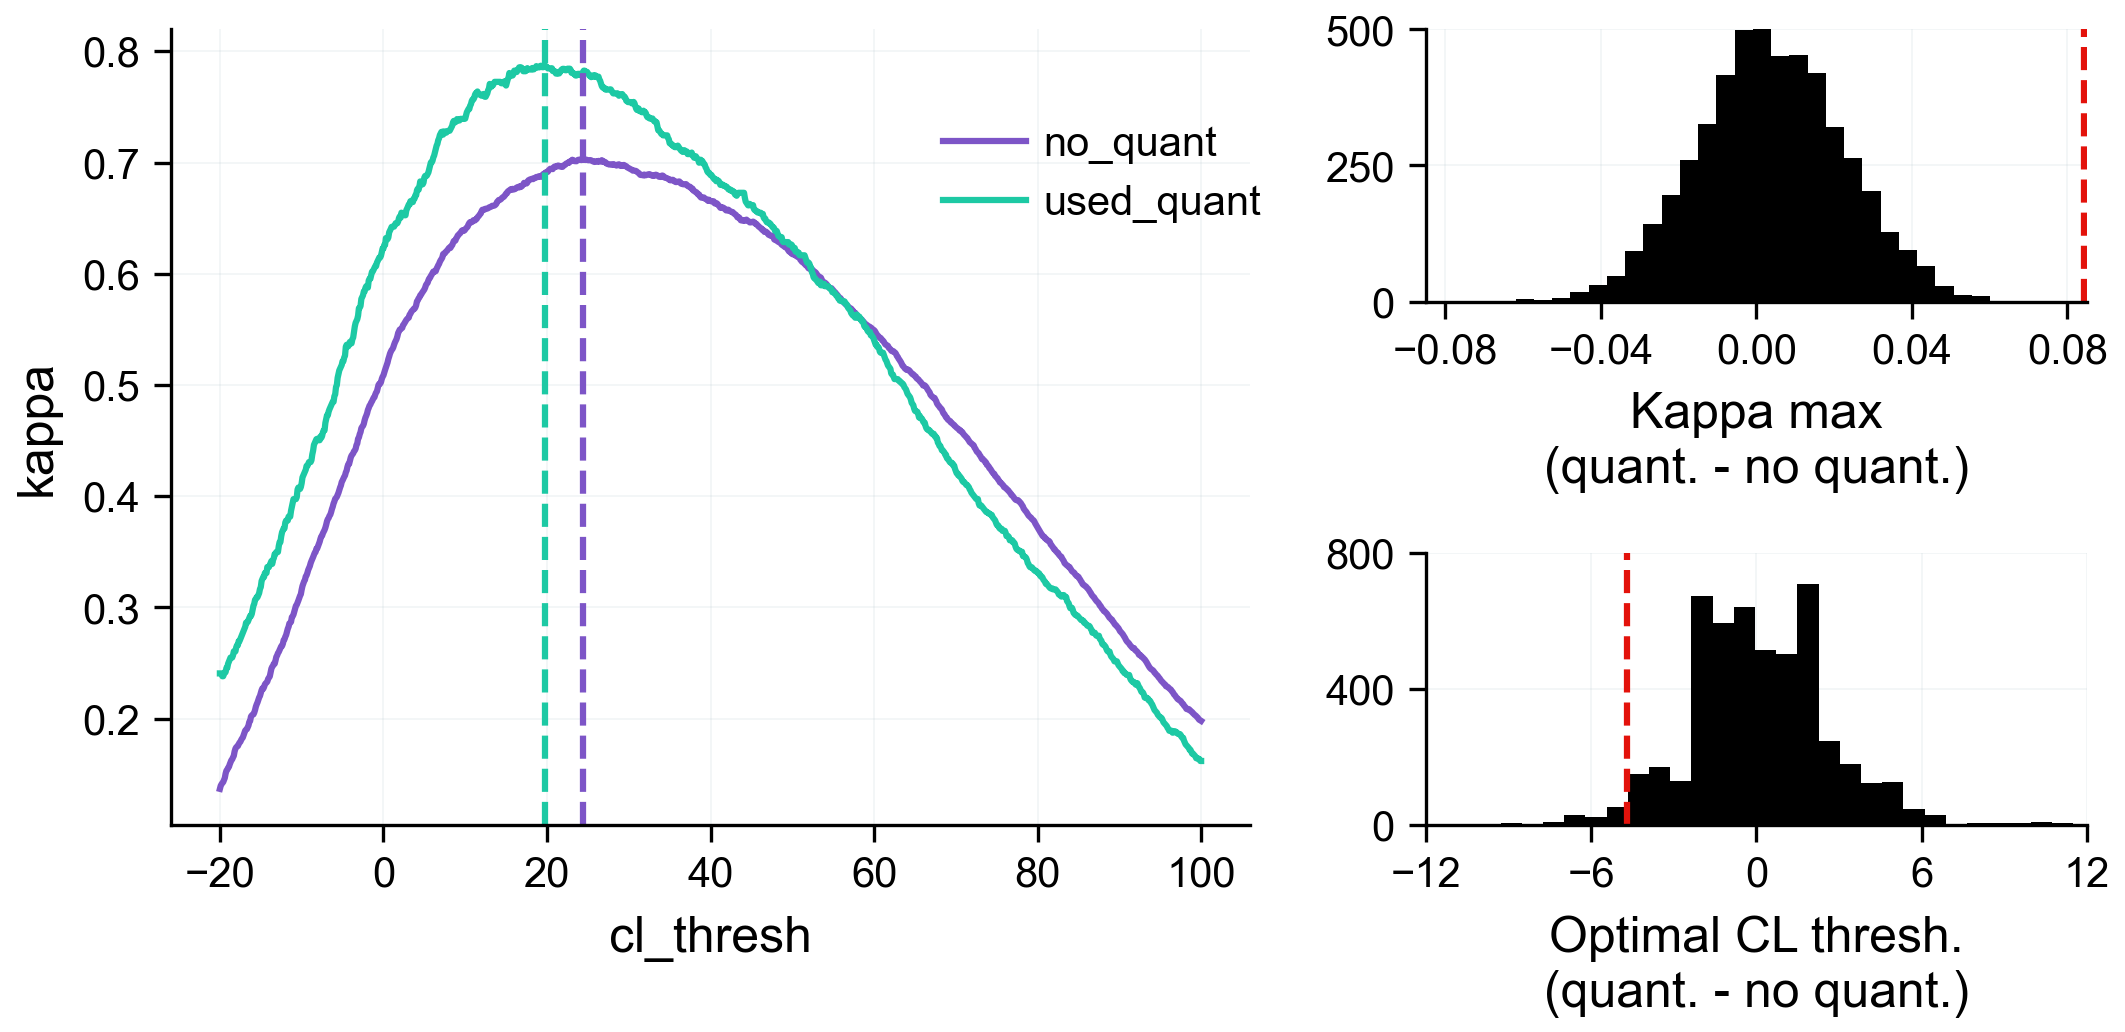

In [80]:
savefig = False
overwrite = True
palette = [co["v3"], co["g"]]

# Max kappa diff:
max_kappa_pval = (
    1 + np.sum(np.abs(max_kappa_diff_resamples) >= np.abs(max_kappa_diff))
) / (1 + n_resamples)
print(f"max_kappa_diff P = {max_kappa_pval:.6f}")

# CL thresh diff:
cl_thresh_pval = (
    1 + np.sum(np.abs(cl_thresh_diff_resamples) >= np.abs(cl_thresh_diff))
) / (1 + n_resamples)
print(f"cl_thresh_diff P = {cl_thresh_pval:.6f}")

# Plot the results.
# Use gridspec to create a new figure with 3 axes
fig = plt.figure(figsize=(colws[3], colws[3] * 0.5))
gs = fig.add_gridspec(2, 5)
ax = [
    fig.add_subplot(gs[:, :3]),
    fig.add_subplot(gs[0, 3:]),
    fig.add_subplot(gs[1, 3:]),
]

iax = 0
_ax = ax[iax]
sns.lineplot(
    x="cl_thresh",
    y="kappa",
    hue="data",
    data=vr_quant.query("(data!='all')"),
    palette=palette,
    lw=lws["line"],
    ax=_ax,
)
for i, d in enumerate(["no_quant", "used_quant"]):
    _ax.axvline(
        x=max_kappa[d]["cl_thresh"],
        color=palette[i],
        linestyle="--",
        linewidth=lws["line"],
    )
# Adjust the legend
leg = _ax.legend(
    bbox_to_anchor=(0.7, 0.9),
    frameon=False,
    fontsize=font["tick"],
    # handlelength=1,
    # handletextpad=0.4,
    markerscale=1,
    title="",
)

iax += 1
_ax = ax[iax]
_ax.hist(max_kappa_diff_resamples, bins=30, color="k")
_ax.axvline(x=max_kappa_diff, color=co["r"], linestyle="--", linewidth=lws["line"])
_ax.set_xlim([-0.085, 0.085])
_ax.set_xticks(np.arange(-0.08, 0.081, 0.04))
_ax.set_xlabel("Kappa max\n(quant. - no quant.)")
_ax.set_ylim([0, 500])
_ax.set_yticks(np.arange(0, 501, 250))

iax += 1
_ax = ax[iax]
_ax.hist(cl_thresh_diff_resamples, bins=30, color="k")
_ax.axvline(x=cl_thresh_diff, color=co["r"], linestyle="--", linewidth=lws["line"])
_ax.set_xlim([-0.08, 0.08])
_ax.set_xticks(np.arange(-12, 12.1, 6))
_ax.set_xlabel("Optimal CL thresh.\n(quant. - no quant.)")
_ax.set_ylim([0, 800])
_ax.set_yticks(np.arange(0, 801, 400))

if savefig:
    outfile = op.join(fig_dir, "vr_quant_kappa_plot.pdf")
    if overwrite or not op.exists(outfile):
        fig.savefig(outfile)
        print(f"Saved {outfile}")

fig.tight_layout()


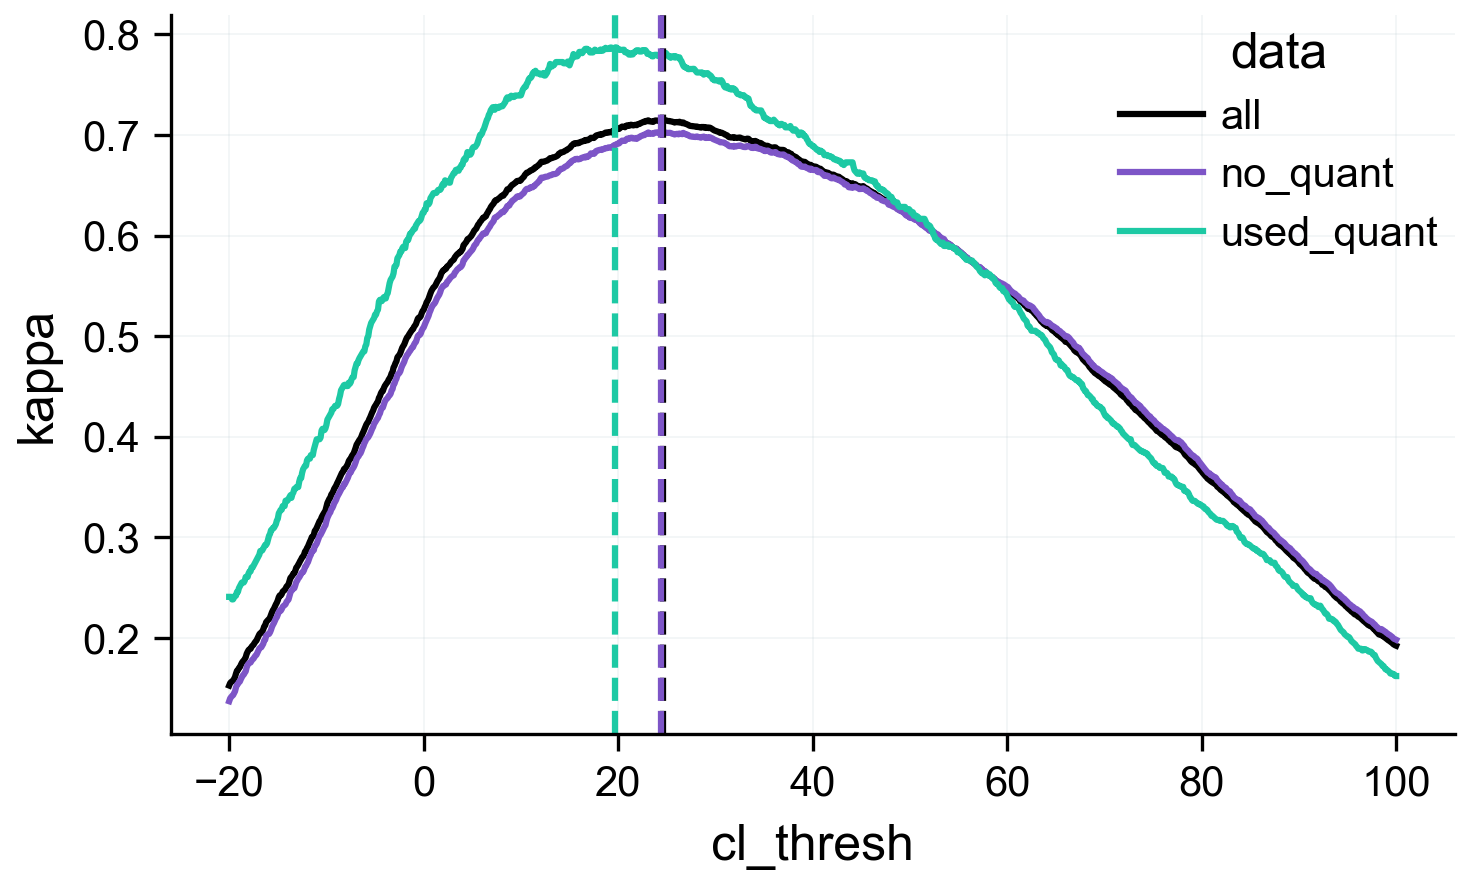

In [ ]:
palette = [co["k"], co["v3"], co["g"]]

fig, ax = plt.subplots(figsize=(colws[3] * 0.7, colws[3] * 0.7 * 0.618034))

sns.lineplot(
    x="cl_thresh", y="kappa", hue="data", data=vr_quant, palette=palette, ax=ax
)
for i, d in enumerate(["all", "no_quant", "used_quant"]):
    ax.axvline(
        x=max_kappa[d]["cl_thresh"],
        color=palette[i],
        linestyle="--",
        linewidth=lws["line"],
    )
